# QSTP Image Recognition with Deep Learning

Name: Shriraj Sawant

Contact: 9923690913

Email: sr.official@hotmail.com


In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms as tforms
from torch.utils.data import Dataset, DataLoader
from mnist import MNIST
import matplotlib.pyplot as plt

%matplotlib inline

#Creating Dataset class for loading FashionMNIST dataset directly from given idx3-ubyte.gz format
class FashionMNIST(Dataset):
    """ Fashion MNIST Dataset """
    def __init__(self, root='.', train=True, transform=None, normalize=False):
        """
        Args:            
            root (string): Directory with all the dataset in .gz form.
            train (boolean): Choice for training or test dataset. By default loads training dataset.
            transform (callable, optional): Optional transform to be applied on a sample.
            normalize (boolean): normalizes dataset, requires dataset to be transformed to Tensor first. 
        """
        self.root = root        
        self.transform = transform
        self.normalize = normalize
        self.images = None
        self.labels = None        
        if train:
            self.images, self.labels = MNIST(path=root, return_type='numpy', gz=True).load_training()
        else:
            self.images, self.labels = MNIST(path=root, return_type='numpy', gz=True).load_testing()        
        self.mean = self.images.mean()
        self.std = self.images.std()
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        image = self.images[idx].astype('float32').reshape(28,28,1)        
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)            
            label = torch.tensor(label.item())
        if self.normalize:
            normtransform=tforms.Compose([tforms.Normalize(mean=[self.mean], std=[self.std])])
            image = normtransform(image)
        return image, label
    
train_dataset = FashionMNIST(root='fashion-mnist-master/data/fashion', 
                             train=True, 
                             transform=tforms.Compose([tforms.ToPILImage(), tforms.RandomHorizontalFlip(p=0.5), tforms.ToTensor()]),
                             normalize=True
                            )
test_dataset = FashionMNIST(root='fashion-mnist-master/data/fashion', 
                            train=False,
                            transform=tforms.Compose([tforms.ToTensor(), tforms.Normalize(mean=[train_dataset.mean], std=[train_dataset.std])])
                           )

batch_size = 500
n_iters = 30000
epochs = int(n_iters*batch_size/len(train_dataset))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

#Deep Neural Network Architecture for training the model
class CNNmodel(nn.Module):
    def __init__(self):
        super(CNNmodel, self).__init__()          
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.ac1 = nn.LeakyReLU()  
        self.drop1 = nn.Dropout2d(0.1)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)      
        self.bn2 = nn.BatchNorm2d(64)
        self.ac2 = nn.LeakyReLU()
        self.drop2 = nn.Dropout2d(0.1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)  
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)    
        self.bn3 = nn.BatchNorm2d(128)
        self.ac3 = nn.LeakyReLU()    
        self.drop3 = nn.Dropout2d(0.1)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)        
        self.ac4 = nn.LeakyReLU()
        self.drop4 = nn.Dropout2d(0.1)
        self.pool4 = nn.MaxPool2d(kernel_size=2) 
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)        
        self.ac5 = nn.LeakyReLU()
        self.drop5 = nn.Dropout2d(0.1)
        
        self.fc1 = nn.Linear(512*7*7, 100)
        self.bno = nn.BatchNorm1d(100)        
        self.aco = nn.LeakyReLU()
        self.dropo = nn.Dropout(0.5)
        self.opl = nn.Linear(100, 10)
        
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.kaiming_normal_(self.conv4.weight)
        nn.init.kaiming_normal_(self.conv5.weight)        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.opl.weight)        
        
    def forward(self, x):
        out = x        
        out = self.conv1(out)   
        out = self.bn1(out)
        out = self.ac1(out)
        out = self.drop1(out)
        
        out = self.conv2(out)    
        out = self.bn2(out)
        out = self.ac2(out)
        out = self.drop2(out)
        out = self.pool2(out)
        
        out = self.conv3(out)    
        out = self.bn3(out)
        out = self.ac3(out)
        out = self.drop3(out)
        
        out = self.conv4(out)
        out = self.bn4(out)        
        out = self.ac4(out)
        out = self.drop4(out)
        out = self.pool4(out)
        
        out = self.conv5(out)    
        out = self.bn5(out)
        out = self.ac5(out)
        out = self.drop5(out)
        
        out = out.view(out.size(0), -1) 
        out = self.fc1(out)
        out = self.bno(out)        
        out = self.aco(out)
        out = self.dropo(out)
        out = self.opl(out)
        return out
    
my_model = CNNmodel()
my_model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(my_model.parameters(), lr = 0.05)

#Training the model
itr = 0
costs=[]
tracc=[]
tsacc=[]
for epoch in range(epochs):
    for images, labels in train_loader:
        images.requires_grad_()
        labels.requires_grad_()
        images=images.cuda()
        labels=labels.cuda()
        
        my_model.train()
        optimizer.zero_grad()
        
        outputs = my_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        itr+=1
        if itr%500 == 0:
            my_model.eval()
            correct = 0
            total = 0            
            for images, labels in test_loader:  
                images=images.cuda()
                outputs = my_model(images)
                _, predicted = torch.max(outputs.data, 1)                
                total+=labels.size(0)
                correct+= (predicted.cpu() == labels.cpu()).sum()    
            test_acc = 100*float(correct)/total
            
            correct = 0
            total = 0
            for images, labels in train_loader:  
                images=images.cuda()
                outputs = my_model(images)
                _, predicted = torch.max(outputs.data, 1)                
                total+=labels.size(0)
                correct+= (predicted.cpu() == labels.cpu()).sum()  
            train_acc = 100*float(correct)/total  
            costs.append(loss)
            tracc.append(train_acc)
            tsacc.append(test_acc)
            print("Iter: {}, Loss: {:.4}, Train set Accuracy: {:.4}, Test set Accuracy: {:.4}".format(itr, loss, train_acc, test_acc))
            
            

Iter: 500, Loss: 0.411, Train set Accuracy: 88.56, Test set Accuracy: 87.6
Iter: 1000, Loss: 0.4293, Train set Accuracy: 90.38, Test set Accuracy: 89.37
Iter: 1500, Loss: 0.3349, Train set Accuracy: 91.64, Test set Accuracy: 90.08
Iter: 2000, Loss: 0.2749, Train set Accuracy: 92.44, Test set Accuracy: 90.74
Iter: 2500, Loss: 0.2902, Train set Accuracy: 92.98, Test set Accuracy: 91.17
Iter: 3000, Loss: 0.2778, Train set Accuracy: 93.78, Test set Accuracy: 91.72
Iter: 3500, Loss: 0.2106, Train set Accuracy: 94.19, Test set Accuracy: 92.16
Iter: 4000, Loss: 0.2253, Train set Accuracy: 94.51, Test set Accuracy: 92.35
Iter: 4500, Loss: 0.2265, Train set Accuracy: 94.83, Test set Accuracy: 92.47
Iter: 5000, Loss: 0.1947, Train set Accuracy: 95.32, Test set Accuracy: 92.86
Iter: 5500, Loss: 0.2231, Train set Accuracy: 95.51, Test set Accuracy: 92.88
Iter: 6000, Loss: 0.2165, Train set Accuracy: 95.89, Test set Accuracy: 92.96
Iter: 6500, Loss: 0.1771, Train set Accuracy: 96.15, Test set Accur

In [2]:
torch.save(my_model,'cnn_94.12.pt')

C:\Users\Shriraj\Anaconda3\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type CNNmodel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


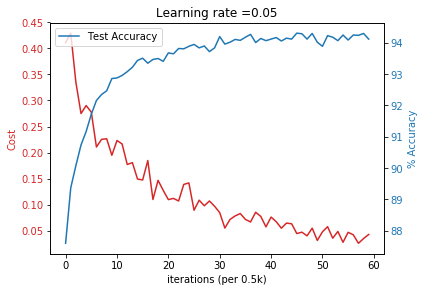

In [10]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('iterations (per 0.5k)')
ax1.set_ylabel('Cost', color=color)
ax1.plot(costs, color=color, label='Costs')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('% Accuracy', color=color)  
ax2.plot(tsacc, color=color, label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title("Learning rate =" + str(0.05))
plt.legend()
plt.show()